# Postprocessing
This notebook summarizes performance metrics of a trained GCN model. It especially plots:
* ROC/PR curves
* The relationship of predictions and node degree
* The overlap of predictions and database cancer genes

In [1]:
import numpy as np
import pandas as pd
import sys, os
import operator

sys.path.append(os.path.abspath('../EMOGI'))
import gcnIO, postprocessing

sys.path.append(os.path.abspath('../pancancer/preprocessing'))
import preprocessing_utils as pre_utils

# set options
np.set_printoptions(suppress=True)
pd.set_option('display.float_format', lambda x: '%.3f' % x)

import matplotlib.pyplot as plt, seaborn as sns
plt.rc('font', family='Helvetica')
%matplotlib inline

## Relevant Paths

* `model_dir`: The directory were a trained EMOGI model is located in. Can be set with the training script.
* `network_name`: The name of the PPI network used. This can be any of: CPDB, Multinet, PCNet, IREF (for IRefIndex from 2015), IREF_new (for a current version of IRefIndex) and STRING (for STRING-db) and should fit with the network used for training.

In [47]:
model_dir = '../data/GCN/training/Rev1_CNA_separated_all_networks/CPDB/'
#model_dir = '../data/GCN/training/final_TCGA_all_networks/CPDB/multiomics/'
network_name = 'CPDB'

In [48]:
args, data_file = gcnIO.load_hyper_params(model_dir)
data = gcnIO.load_hdf_data(os.path.join(model_dir, data_file))
adj, features, y_train, y_val, y_test, train_mask, val_mask, test_mask, node_names, feat_names = data
print ("Data comes from {}".format(data_file))
print (args)
CLASSIFICATION_THRESHOLD = 0.7337269395589828


Data comes from ../../../../pancancer/rev1_container_all_networks_CNA_separated/CPDB_multiomics_cnaseparate_samesplit.h5
{'epochs': 5000, 'lr': 0.001, 'support': 1, 'hidden_dims': [300, 100], 'loss_mul': 45.0, 'decay': 0.005, 'dropout': 0.5, 'data': '../../../../pancancer/rev1_container_all_networks_CNA_separated/CPDB_multiomics_cnaseparate_samesplit.h5', 'cv_runs': 10}


## Predictions
I want to see what the GCN predicts and if those predictions make any sense.

In [49]:
all_preds, all_sets = postprocessing.compute_ensemble_predictions(model_dir)
#postprocessing.compute_node_degree_relation(model_dir)
postprocessing.compute_average_ROC_curve(model_dir, all_preds, all_sets)
postprocessing.compute_average_PR_curve(model_dir, all_preds, all_sets)

Read predictions from 10 CV runs


In [50]:
predictions = pd.read_csv(os.path.join(model_dir, 'ensemble_predictions.tsv'),
                                    sep='\t', header=0)
nodes = pd.DataFrame(node_names, columns=['ID', 'Name']).set_index('ID')
nodes = nodes[~nodes.index.duplicated()]
pred_ordered = predictions[~predictions.index.duplicated()]
pred_ordered.reindex(index=nodes.index)
predictions.set_index('ID', inplace=True)
predictions.drop([c for c in predictions.columns if c.startswith('Prob_pos')], axis=1, inplace=True)
predictions.columns = ['Name', 'label', 'Num_Pos', 'Prob_pos', 'Std_Pred']

## Enrich predictions and plot relationship to node degree

In [51]:
features_df = pd.DataFrame(features, index=node_names[:, 0])
features_df['Name'] = node_names[:, 1]
features_df['neighbors'] = adj.sum(axis=0)
pred_with_feat = features_df.join(predictions, how='inner', lsuffix='_')
pos_predicted = pred_with_feat[pred_with_feat.Prob_pos > CLASSIFICATION_THRESHOLD]

# add columns to distinguish between training and test set
labels_df = pd.DataFrame(node_names, index=node_names[:, 0], columns=['ID', 'Name']).drop(['ID'], axis=1)
labels_df['positive'] = (y_train[:,0] | y_test[:,0] | y_val[:, 0])
labels_df['training_set'] = train_mask
labels_df['testing_set'] = test_mask
labels_df['validation_set'] = val_mask
labels_df['label'] = np.logical_or(train_mask, test_mask, val_mask).astype(int)
labels_df['negative'] = labels_df.label & ~labels_df.positive

# show the ones that are most confidently predicted
print ("Predicted {} genes of {} total to be involved with cancer".format(pos_predicted.shape[0], predictions.shape[0]))
pos_nofeat = predictions[predictions.Prob_pos >= CLASSIFICATION_THRESHOLD]
pos_nofeat.sort_values(by='Prob_pos', ascending=False).to_csv(os.path.join(model_dir, 'positive_prediction.txt'),
                                                                 sep='\t')

Predicted 4239 genes of 13627 total to be involved with cancer


In [52]:
labels_with_pred = labels_df.join(predictions, lsuffix='_', how='inner')
predictions_for_pos = labels_with_pred[labels_with_pred.positive == 1]
true_positives = predictions_for_pos[predictions_for_pos.Prob_pos > CLASSIFICATION_THRESHOLD]
no_tp = true_positives.shape[0]
no_positives = predictions_for_pos.shape[0]
pred_pos_test = true_positives[true_positives.testing_set == 1]
pred_pos_train = true_positives[true_positives.training_set == 1]
predictions_for_neg = labels_with_pred[labels_with_pred.negative == 1]
true_negatives = predictions_for_neg[predictions_for_neg.Prob_pos <= CLASSIFICATION_THRESHOLD]
no_tn = true_negatives.shape[0]
no_fn = predictions_for_neg[predictions_for_neg.Prob_pos > CLASSIFICATION_THRESHOLD].shape[0]

print ("Predicted {} out of {} known infection genes".format(no_tp, no_positives)
      )
print ("Out of these {}, {} were not shown during training.".format(no_positives,
                                                                    y_test[:, 0].sum())
      )
print ("Predicted {} out of {} test genes ({}%)".format(pred_pos_test.shape[0],
                                                        y_test[:,0].sum(),
                                                        pred_pos_test.shape[0]/y_test[:,0].sum()*100.)
      )
print ("Predicted {} out of {} train genes ({}%)".format(pred_pos_train.shape[0],
                                                         y_train[:,0].sum(),
                                                         pred_pos_train.shape[0]/y_train[:,0].sum()*100.)
      )
print ("Correctly rejected {} out of {} genes (True Negatives) ({}%)".format(no_tn,
                                                                     predictions_for_neg.shape[0],
                                                                     no_tn/predictions_for_neg.shape[0]*100.))
print ("Falsely predicted {} negatives (FN)".format(no_fn))
predictions_for_neg.sort_values(by='Prob_pos', ascending=False).head(20)

Predicted 714 out of 787 known infection genes
Out of these 787, 199 were not shown during training.
Predicted 144 out of 199 test genes (72.36180904522614%)
Predicted 515 out of 537 train genes (95.90316573556798%)
Correctly rejected 1685 out of 1991 genes (True Negatives) (84.63083877448518%)
Falsely predicted 306 negatives (FN)


,Name_,positive,training_set,testing_set,validation_set,label_,negative,Name,label,Num_Pos,Prob_pos,Std_Pred
ENSG00000100603,SNW1,False,True,False,False,1,True,SNW1,False,10,1.000,0.000
ENSG00000134308,YWHAQ,False,False,True,False,1,True,YWHAQ,False,10,1.000,0.000
ENSG00000105325,FZR1,False,True,False,False,1,True,FZR1,False,10,1.000,0.000
ENSG00000158092,NCK1,False,True,False,False,1,True,NCK1,False,10,1.000,0.000
ENSG00000114166,KAT2B,False,True,False,False,1,True,KAT2B,False,10,1.000,0.000
ENSG00000196363,WDR5,False,True,False,False,1,True,WDR5,False,10,1.000,0.000
ENSG00000100629,CEP128,False,False,True,False,1,True,CEP128,False,10,1.000,0.000
ENSG00000135250,SRPK2,False,False,True,False,1,True,SRPK2,False,10,1.000,0.000
ENSG00000188612,SUMO2,False,False,True,False,1,True,SUMO2,False,10,1.000,0.000
ENSG00000107854,TNKS2,False,True,False,False,1,True,TNKS2,False,10,1.000,0.000


<AxesSubplot:xlabel='Prob_pos'>

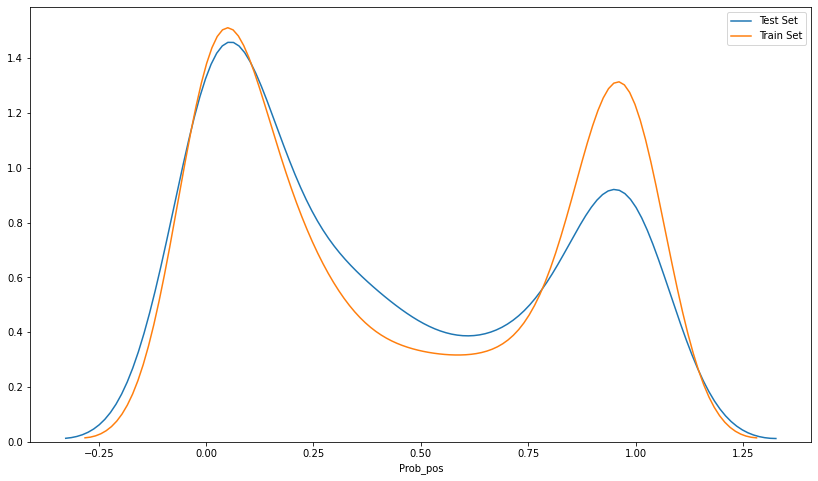

In [53]:
fig = plt.figure(figsize=(14, 8))
sns.distplot(labels_with_pred[labels_with_pred.testing_set].Prob_pos, hist=False, label='Test Set')
sns.distplot(labels_with_pred[labels_with_pred.training_set].Prob_pos, hist=False, label='Train Set')

## Train other Classifiers on the Features for Comparison
In order to evaluate our method, let's compare it's power to other algorithms. For now, I'll focus on ones, that operate on the features alone and algorithms that operate on the network alone.
The comparison is with:
* **SVM classifier**: A very powerful, non-linear method that generally does not really overfit and can deal with little data. This should be an upper bound on what one can reach on the features alone.
* **Logistic regression**: This is a linear algorithm, also only operating on the features. It is less powerful than an SVM.
* **PageRank**: A network ranking method that only computes the most important nodeso in the network. It's completely blind to the features.

In [58]:
best_thr_roc, best_thr_pr = postprocessing.compute_ROC_PR_competitors(model_dir, network_name=network_name,
                                                                      plot_correlations=False)
print ("Best cutoff for EMOGI Score: {0:.2f}".format(best_thr_pr))

/project/gcn/diseasegcn/EMOGI/postprocessing.py:676: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pr_pred_test.drop_duplicates(inplace=True)
findfont: Font family ['Helvetica'] not found. Falling back to DejaVu Sans.


EMOGI EMOGI
Random Forest Random_Forest
DeepWalk DeepWalk
PageRank PageRank
Net. Prop. RWR
MutSigCV MutSigCV
DeepWalk + Features RF RF_dwfeat
20/20+ 2020plus
GCN Network Only GCN_Featureless
Best cutoff for EMOGI Score: 0.73


In [54]:
performance_all, performance_test = postprocessing.compute_predictions_competitors(model_dir=model_dir,
                                                                                   network_name=network_name,
                                                                                   network_measures=False,
                                                                                   plot_correlations=False,
                                                                                   verbose=False
                                                                                  )

/project/gcn/diseasegcn/EMOGI/postprocessing.py:676: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pr_pred_test.drop_duplicates(inplace=True)


In [55]:
data = postprocessing.get_training_data(model_dir)
network, features, y_train, y_val, y_test, train_mask, val_mask, test_mask, node_names, feat_names = data
cutoff = postprocessing.get_optimal_cutoff(predictions, node_names, test_mask, y_test, colname='Prob_pos')
cutoff

0.7337269395589828


EMOGI
Random_Forest
DeepWalk
RF_dwfeat
GCN_Featureless
2020plus
PageRank
RWR
MutSigCV


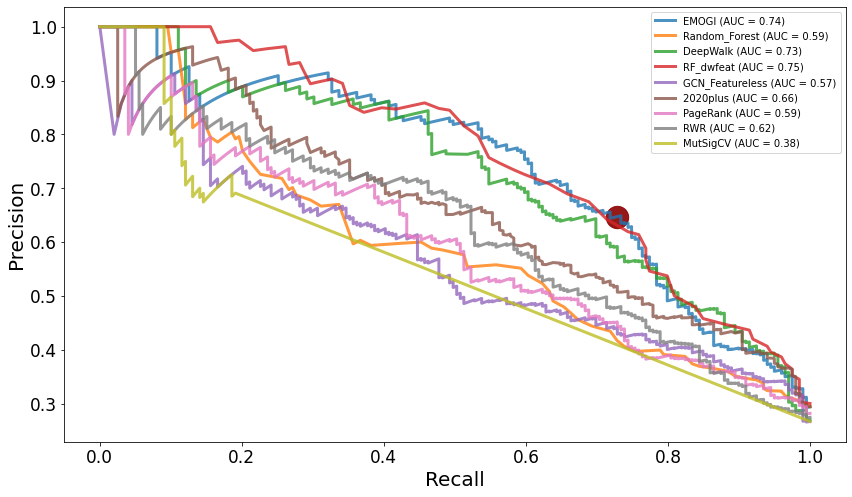

In [56]:
from sklearn.metrics import average_precision_score, precision_recall_curve, precision_score, recall_score
fig = plt.figure(figsize=(14, 8))
y_true = y_test[test_mask == 1, 0]
for col in performance_all.drop('ID', axis=1).columns:
    print (col)
    pr, rec, thresholds = precision_recall_curve(y_true=y_true, probas_pred=performance_test[col])
    auc = average_precision_score(y_true=y_true, y_score=performance_test[col])
    plt.plot(rec, pr, lw=3, label='{0} (AUC = {1:.2f})'.format(col, auc), alpha=0.8)
preds_test = performance_test['EMOGI']
prec = precision_score(y_true, preds_test > cutoff)
rec = recall_score(y_true, preds_test > cutoff)
plt.scatter(rec, prec, s=500, alpha=0.9, c='darkred')
plt.xlabel('Recall', fontsize=20)
plt.ylabel('Precision', fontsize=20)
plt.tick_params(axis='both', labelsize=17)
plt.legend()

## Compute Overlap with other Datasets

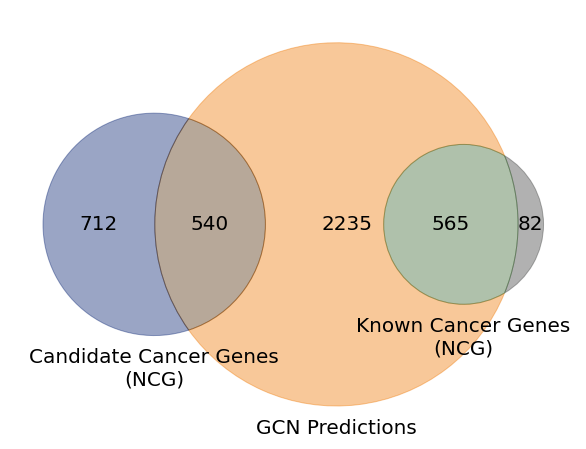

In [61]:
known_cancer_genes = []
candidate_cancer_genes = []
n = 0
with open('../data/pancancer/NCG/cancergenes_list.txt', 'r') as f:
    for line in f.readlines():
        n += 1
        if n == 1:
            continue
        l = line.strip().split('\t')
        if len(l) == 2:
            known_cancer_genes.append(l[0])
            candidate_cancer_genes.append(l[1])
        else:
            candidate_cancer_genes.append(l[0])

known_cancer_genes_innet = nodes[nodes.Name.isin(known_cancer_genes)].Name
candidate_cancer_genes_innet = nodes[nodes.Name.isin(candidate_cancer_genes)].Name

remove_blood_cancer_genes = False
if remove_blood_cancer_genes:
    # load cgc
    cgc = pd.read_csv('../data/pancancer/cosmic/cancer_gene_census.csv')
    cgc.dropna(subset=['Tissue Type'], inplace=True)

    # find blood cancer genes based on these abbreviations (E=Epithelial, M=Mesenchymal, O=Other, L=Leukaemia/lymphoma)
    pattern = '|'.join(['E', 'O', 'M', 'E;'])
    non_blood_cancer_genes = cgc[cgc['Tissue Type'].str.contains(pattern)]
    blood_cancer_genes = cgc[~cgc['Tissue Type'].str.contains(pattern)]
    known_cancer_genes_innet = non_blood_cancer_genes[non_blood_cancer_genes['Gene Symbol'].isin(known_cancer_genes_innet)]['Gene Symbol']
    print ("Left with {} known cancer genes after blood removal".format(known_cancer_genes_innet.shape[0]))

postprocessing.compute_overlap(model_dir, 'overlap_NCG.svg',
                               known_cancer_genes_innet, candidate_cancer_genes_innet,
                               .85,
                               ['Known Cancer Genes\n(NCG)', 'Candidate Cancer Genes\n(NCG)']
                              )

## Consensus **New** Predictions Across All Networks & Omics

In [16]:
all_models_dir = '../data/GCN/training/final_TCGA_all_networks/'
top_n = 100
all_omics = False


consensus_predicted = {}
checked_models = 0
for network in os.listdir(all_models_dir):
    print (network)
    network_path = os.path.join(all_models_dir, network)
    if all_omics:
        if os.path.isdir(network_path) and not network.startswith('.'):
            for omics in os.listdir(network_path):
                model_path = os.path.join(network_path, omics)
                if os.path.isdir(model_path) and not omics.startswith('.'):
                    predictions_topn = postprocessing.load_predictions(model_path).head(top_n)
                    non_cancer_hits = predictions_topn[~predictions_topn.label]
                    for gene in non_cancer_hits.Name:
                        if not gene in consensus_predicted:
                            consensus_predicted[gene] = 1
                        else:
                            consensus_predicted[gene] += 1
                    checked_models += 1
    else:
        if os.path.isdir(network_path) and os.path.isdir(os.path.join(network_path, 'multiomics')):
            model_path = os.path.join(network_path, 'multiomics')
            predictions_topn = postprocessing.load_predictions(model_path).head(top_n)
            non_cancer_hits = predictions_topn[~predictions_topn.label]
            for gene in non_cancer_hits.Name:
                if not gene in consensus_predicted:
                    consensus_predicted[gene] = 1
                else:
                    consensus_predicted[gene] += 1
            checked_models += 1

print ("{} different non-cancer genes in top {} predictions across all 7 omics data types!".format(len(consensus_predicted), top_n))
consensus_sorted = sorted(consensus_predicted.items(), key=operator.itemgetter(1), reverse=True)

CPDB
Multinet
STRING-db
IRefIndex_old
IRefIndex
PCNet
consensus_genes_all_omics.svg
consensus_neighbors_all_networks.svg
ncgknown_neighbors_consensus.svg
consensus_genes_multiomics.svg
consensus_genes_achilles_affected_celllines.svg
consensus_candidates.tsv
consensus_nonaffected_notknown.tsv
consensus_nonaffected_notknown_pathways.txt
Overall_Survival_FOS.svg
Overall_Survival_CDK2.svg
Overall_Survival_SP1.svg
Overall_Survival_IQGAP1.svg
Overall_Survival_YWHAQ.svg
Overall_Survival_HDAC2.svg
Overall_Survival_FYN.svg
Overall_Survival_GRB2.svg
Overall_Survival_HDAC1.svg
Disease_Free_Survival_YWHAZ.svg
survival_LIHC_HDAC1.pdf
correlation_cginteractions.svg
achilles_effects_genesets.svg
consensus_neighbors_all_networks_withrandom.svg
consensus_candidates_pathways.txt
achilles_effects_twothirds.svg
aupr_heatmap.svg
212 different non-cancer genes in top 100 predictions across all 7 omics data types!


/home/sasse/anaconda3/lib/python3.7/site-packages/matplotlib/font_manager.py:1241: UserWarning: findfont: Font family ['Helvetica'] not found. Falling back to DejaVu Sans.
  (prop.get_family(), self.defaultFamily[fontext]))


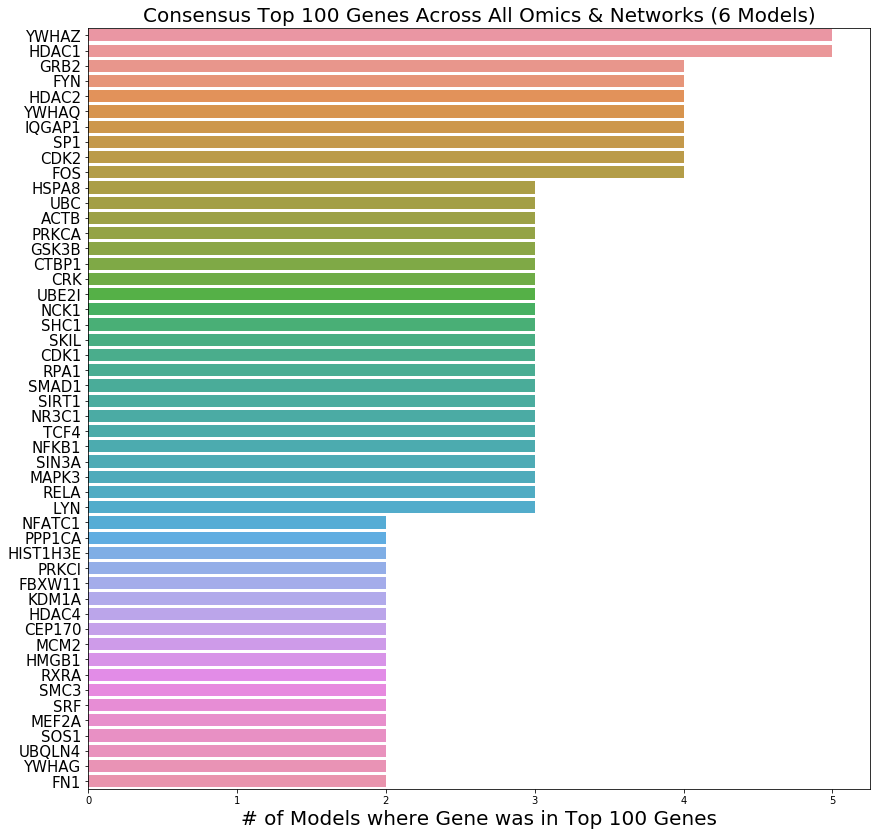

In [17]:
to_plot = consensus_sorted[:50]
fig = plt.figure(figsize=(14, 14))
sns.barplot(y=[i[0] for i in to_plot], x=[i[1] for i in to_plot], orient='h')
plt.title('Consensus Top {} Genes Across All Omics & Networks ({} Models)'.format(top_n, checked_models), size=20)
plt.xlabel('# of Models where Gene was in Top {} Genes'.format(top_n), size=20)
plt.gca().tick_params(axis='y', labelsize=15)
fig.savefig(os.path.join(all_models_dir, 'consensus_genes_{}omics.svg'.format('all_' if all_omics else 'multi')))

In [18]:
def get_cancer_genes_for_net(model_dir):
    if model_dir.endswith('.h5'):
        data = gcnIO.load_hdf_data(model_dir)
    else:
        data = _get_training_data(model_dir)
    network, features, y_train, y_val, y_test, train_mask, val_mask, test_mask, node_names, feat_names = data
    nodes = pd.DataFrame(node_names, columns=['ID', 'Name'])
    nodes['label'] = np.logical_or(np.logical_or(y_train, y_test), y_val)

    # get the NCG cancer genes
    known_cancer_genes = []
    candidate_cancer_genes = []
    n = 0
    with open('../data/pancancer/NCG/cancergenes_list.txt', 'r') as f:
        for line in f.readlines():
            n += 1
            if n == 1:
                continue
            l = line.strip().split('\t')
            if len(l) == 2:
                known_cancer_genes.append(l[0])
                candidate_cancer_genes.append(l[1])
            else:
                candidate_cancer_genes.append(l[0])
    known_cancer_genes_innet = nodes[nodes.Name.isin(known_cancer_genes)].Name
    candidate_cancer_genes_innet = nodes[nodes.Name.isin(candidate_cancer_genes)].Name

    oncokb_genes = pd.read_csv('/project/gcn/diseasegcn/data/pancancer/oncoKB/cancerGeneList.txt', sep='\t')
    # remove low confidence genes
    oncokb_no_ncg_highconf = oncokb_genes#[oncokb_genes['OncoKB Annotated'] == 'Yes']
    oncokb_no_ncg_highconf = oncokb_no_ncg_highconf[oncokb_no_ncg_highconf['# of occurrence within resources (Column D-J)'] >= 3]
    # remove all NCG genes
    oncokb_no_ncg = oncokb_no_ncg_highconf[~oncokb_no_ncg_highconf['Hugo Symbol'].isin(known_cancer_genes_innet)]
    candidate_cancer_genes_innet = candidate_cancer_genes_innet[~candidate_cancer_genes_innet.isin(oncokb_no_ncg)]
    #oncokb_no_ncg = oncokb_no_ncg[~oncokb_no_ncg['Hugo Symbol'].isin(candidate_cancer_genes_innet)]
    # remove genes that are not in the network
    oncokb_innet = nodes[nodes.Name.isin(oncokb_no_ncg['Hugo Symbol'])].Name
    return oncokb_innet, candidate_cancer_genes_innet, known_cancer_genes_innet

def _get_digsee_genes(base_dir, nodes, to_be_removed, threshold):
    pan_cancer_genes = []
    for f in os.listdir(base_dir):
        if f.startswith('mutation') or f.startswith('expression') or f.startswith('methylation'):
            ctype = f.split('.')[0].split('_')[1]
            fname = os.path.join(base_dir, f)
            evidence = pd.read_csv(fname, sep='\t')
            high_scores = evidence[evidence['EVIDENCE SENTENCE SCORE'] >= threshold]
            pan_cancer_genes += high_scores['GENE SYMBOL'].tolist()
    pan_cancer_genes_filtered = [i for i in pan_cancer_genes if not i in to_be_removed]
    return nodes[nodes.Name.isin(pan_cancer_genes)].Name

def _get_training_data(training_dir):
    args, data_file = gcnIO.load_hyper_params(training_dir)
    if os.path.isdir(data_file): # FIXME: This is hacky and not guaranteed to work at all!
        network_name = None
        for f in os.listdir(data_file):
            if network_name is None:
                network_name = f.split('_')[0].upper()
            else:
                assert (f.split('_')[0].upper() == network_name)
        fname = '{}_{}.h5'.format(network_name, training_dir.strip('/').split('/')[-1])
        data_file = os.path.join(data_file, fname)
    data = gcnIO.load_hdf_data(data_file)
    return data

def get_all_digsee_sets(train_dir, threshold=0.3):
    if train_dir.endswith('.h5'):
        data = gcnIO.load_hdf_data(train_dir)
    else:
        data = _get_training_data(train_dir)
    network, features, y_train, y_val, y_test, train_mask, val_mask, test_mask, node_names, feat_names = data
    nodes = pd.DataFrame(node_names, columns=['ID', 'Name'])
    to_be_removed = nodes[np.logical_or(y_train.reshape(-1), y_val.reshape(-1))].Name
    expr_genes = _get_digsee_genes('/project/gcn/diseasegcn/data/pancancer/digSEE/expression/', nodes, to_be_removed, threshold)
    meth_genes = _get_digsee_genes('/project/gcn/diseasegcn/data/pancancer/digSEE/methylation/', nodes, to_be_removed, threshold)
    muta_genes = _get_digsee_genes('/project/gcn/diseasegcn/data/pancancer/digSEE/mutation/', nodes, to_be_removed, threshold)
    return muta_genes, meth_genes, expr_genes

In [19]:
oncoKB, ncg_cand, ncg_known = get_cancer_genes_for_net(model_dir)
ds_mut, ds_meth, ds_expr = get_all_digsee_sets(model_dir, threshold=0.7)
ds_mut.shape, ds_meth.shape, ds_expr.shape

((945,), (0,), (1709,))

In [14]:
top_1000_pred = pred_ordered.head(1000)
num_known_in_top = top_1000_pred[top_1000_pred.Name.isin(ncg_known)].shape[0]
num_cand_in_top = top_1000_pred[top_1000_pred.Name.isin(ncg_cand)].shape[0]
num_onco_in_top = top_1000_pred[top_1000_pred.Name.isin(oncoKB)].shape[0]

ds_overlap_top_1000 = [top_1000_pred.Name.isin(omics).sum() for omics in [ds_mut, ds_meth, ds_expr]]
all_literature = pd.concat((ncg_known, ncg_cand, oncoKB, ds_mut, ds_meth, ds_expr))

print ("Our top 1000 predictions contain {}/{} known cancer genes".format(num_known_in_top, known_cancer_genes_innet.shape[0]))
print ("Our top 1000 predictions contain {}/{} candidate cancer genes".format(num_cand_in_top, candidate_cancer_genes_innet.shape[0]))
print ("Our top 1000 predictions contain {}/{} OncoKB cancer genes".format(num_onco_in_top, oncoKB.shape[0]))
print ("Our top 1000 predictions contain {}/{} DigSEE mutation pancancer genes".format(ds_overlap_top_1000[0], ds_mut.shape[0]))
print ("Our top 1000 predictions contain {}/{} DigSEE methylation pancancer genes".format(ds_overlap_top_1000[1], ds_meth.shape[0]))
print ("Our top 1000 predictions contain {}/{} DigSEE expression pancancer genes".format(ds_overlap_top_1000[2], ds_expr.shape[0]))
print ("Our top 1000 predictions contain {}/{} literature genes (all of the above)".format(top_1000_pred.Name.isin(all_literature).sum(), all_literature.shape[0]))
print ("We consider {} genes in total".format(pred_ordered.shape[0]))

NameError: name 'ncg_known' is not defined

In [21]:
ncg_known.shape

(654,)

In [23]:
above_thr = pred_ordered[pred_ordered.Mean_Pred >= best_thr_pr]
num_known_in_top = above_thr[above_thr.Name.isin(ncg_known)].shape[0]
num_cand_in_top = above_thr[above_thr.Name.isin(ncg_cand)].shape[0]
num_onco_in_top = above_thr[above_thr.Name.isin(oncoKB)].shape[0]

ds_overlap_positive = [above_thr.Name.isin(omics).sum() for omics in [ds_mut, ds_meth, ds_expr]]
all_literature = pd.concat((ncg_known, ncg_cand, oncoKB, ds_mut, ds_meth, ds_expr))

print ("Our positive predictions contain {}/{} known cancer genes".format(num_known_in_top, ncg_known.shape[0]))
print ("Our positive predictions contain {}/{} candidate cancer genes".format(num_cand_in_top, ncg_cand.shape[0]))
print ("Our positive predictions contain {}/{} OncoKB cancer genes".format(num_onco_in_top, oncoKB.shape[0]))
print ("Our positive predictions contain {}/{} DigSEE mutation pancancer genes".format(ds_overlap_positive[0], ds_mut.shape[0]))
print ("Our positive predictions contain {}/{} DigSEE methylation pancancer genes".format(ds_overlap_positive[1], ds_meth.shape[0]))
print ("Our positive predictions contain {}/{} DigSEE expression pancancer genes".format(ds_overlap_positive[2], ds_expr.shape[0]))
print ("Our positive predictions contain {}/{} literature genes (all of the above)".format(above_thr.Name.isin(all_literature).sum(), all_literature.shape[0]))
print ("We consider {} genes in total".format(above_thr.shape[0]))

Our positive predictions contain 445/654 known cancer genes
Our positive predictions contain 383/1287 candidate cancer genes
Our positive predictions contain 103/199 OncoKB cancer genes
Our positive predictions contain 372/945 DigSEE mutation pancancer genes
Our positive predictions contain 0/0 DigSEE methylation pancancer genes
Our positive predictions contain 617/1709 DigSEE expression pancancer genes
Our positive predictions contain 1272/4794 literature genes (all of the above)
We consider 2277 genes in total


In [139]:
def get_all_neighbors(gene, A, node_names):
    nodes = [x[1] for x in node_names]
    if gene in nodes:
        idx = nodes.index(gene)
        interaction_partners_idx = np.where(A[idx, :] == 1)[0]
        interaction_partners = node_names[interaction_partners_idx]
        return interaction_partners
    else:
        return [(None, None)]

In [140]:
consensus_neighbors = {}
for gene, num_predicted in consensus_sorted:
    partners = get_all_neighbors(gene, adj, node_names)
    for partner_id, partner_name in partners:
        if partner_name in consensus_neighbors:
            consensus_neighbors[partner_name] += 1
        else:
            consensus_neighbors[partner_name] = 1

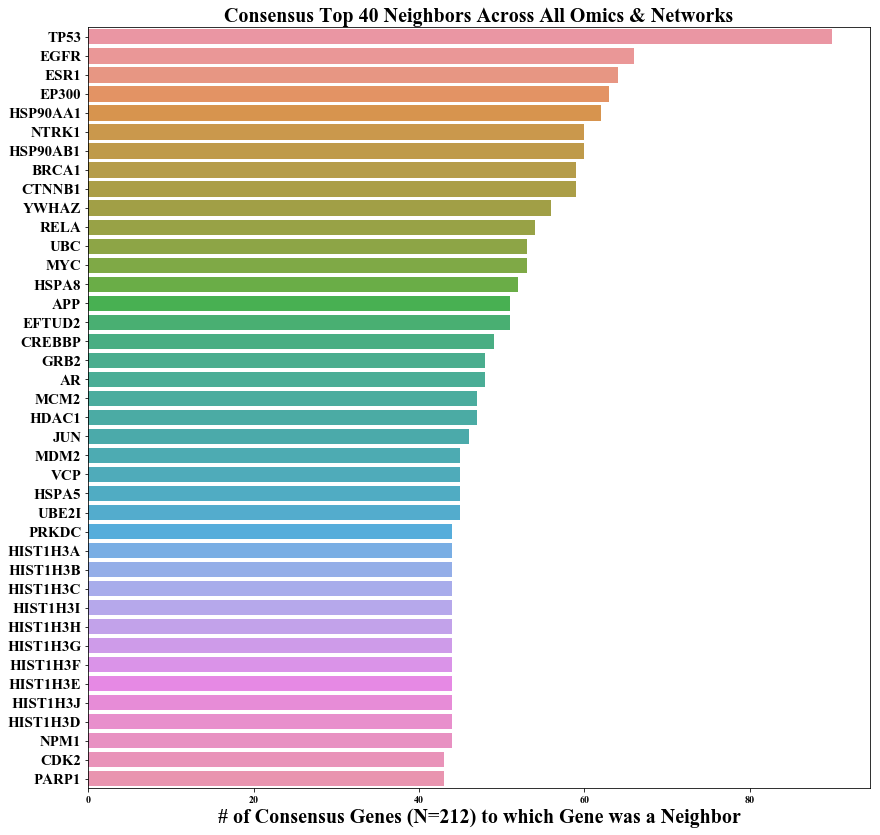

In [141]:
neighbors_sorted = sorted(consensus_neighbors.items(), key=operator.itemgetter(1), reverse=True)
to_plot = neighbors_sorted[:50]
fig = plt.figure(figsize=(14, 14))
sns.barplot(y=[i[0] for i in to_plot], x=[i[1] for i in to_plot], orient='h')
plt.title('Consensus Top 50 Neighbors Across All Omics & Networks'.format(checked_models), size=20)
plt.xlabel('# of Consensus Genes (N={}) to which Gene was a Neighbor'.format(len(consensus_sorted)), size=20)
plt.gca().tick_params(axis='y', labelsize=15)
#fig.savefig(os.path.join(all_models_dir, 'consensus_neighbors_all_networks.svg'))

In [142]:
cancer_gene_neighbors = {}
for cancer_gene in known_cancer_genes_innet:
    
    partners = get_all_neighbors(cancer_gene, adj, node_names)
    for partner_id, partner_name in partners:
        if partner_name in cancer_gene_neighbors:
            cancer_gene_neighbors[partner_name] += 1
        else:
            cancer_gene_neighbors[partner_name] = 1

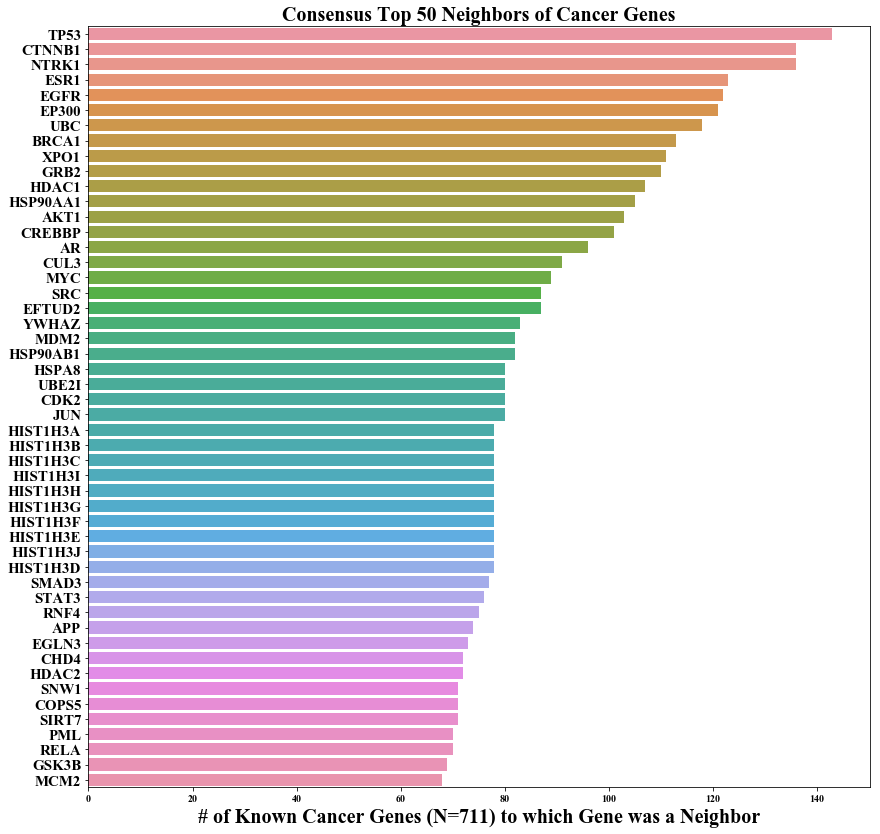

In [143]:
cancer_gene_neighbors_sorted = sorted(cancer_gene_neighbors.items(), key=operator.itemgetter(1), reverse=True)
to_plot = cancer_gene_neighbors_sorted[:50]
fig = plt.figure(figsize=(14, 14))
sns.barplot(y=[i[0] for i in to_plot], x=[i[1] for i in to_plot], orient='h')
plt.title('Consensus Top 50 Neighbors of Cancer Genes', size=20)
plt.xlabel('# of Known Cancer Genes (N={}) to which Gene was a Neighbor'.format(len(known_cancer_genes)), size=20)
plt.gca().tick_params(axis='y', labelsize=15)
fig.savefig(os.path.join(all_models_dir, 'ncgknown_neighbors_consensus.svg'))

## Are the Consensus Genes Essential in Cell Lines?
In this section, I want to check the following:

* In how many cell lines are our consensus genes essential (the population reduces significantly in size; CERES score below -0.5)
* How is the correlation between our output probability and the number of affected cell lines
* Come up with a list of potentially druggable new cancer genes

In [79]:
essential_genes = pd.read_csv('../data/pancancer/Achilles/Achilles_gene_effect.csv').T
essential_genes.columns = essential_genes.loc['Unnamed: 0']
essential_genes.drop('Unnamed: 0', inplace=True)
essential_genes['Name'] = [i.split('(')[0].strip() for i in essential_genes.index]
essential_genes.set_index('Name', inplace=True)
essential_genes.head()

Unnamed: 0,ACH-000004,ACH-000005,ACH-000007,ACH-000009,ACH-000011,ACH-000012,ACH-000013,ACH-000014,ACH-000015,ACH-000017,...,ACH-001736,ACH-001737,ACH-001740,ACH-001745,ACH-001750,ACH-001765,ACH-001814,ACH-001838,ACH-001956,ACH-001957
Name,,,,,,,,,,,,,,,,,,,,,
A1BG,0.169,-0.069,0.054,0.060,0.277,0.008,0.062,0.143,-0.091,0.178,...,0.155,-0.050,0.005,0.209,0.045,0.136,0.217,-0.086,-0.077,0.056
A1CF,0.089,0.219,0.081,-0.011,0.085,0.167,0.039,-0.036,0.008,0.107,...,0.019,0.190,0.349,0.154,0.127,0.021,-0.172,0.083,0.109,0.005
A2M,-0.197,0.178,-0.060,-0.054,0.008,0.089,-0.044,0.011,-0.186,-0.068,...,-0.125,-0.079,-0.195,-0.135,-0.082,-0.107,-0.265,-0.148,0.021,0.068
A2ML1,-0.021,0.158,0.153,0.061,0.446,0.308,0.200,0.183,0.112,0.110,...,0.052,0.101,0.218,0.168,0.133,0.076,0.046,0.257,0.204,0.199
A3GALT2,0.039,-0.194,0.087,0.040,-0.037,0.015,-0.070,-0.034,-0.034,-0.196,...,-0.197,0.164,-0.052,-0.130,-0.172,-0.117,0.124,-0.055,-0.081,-0.043


In [78]:
def get_number_of_affected_cellines(gene_name, achilles_data):
    # we only consider negative effects of knockouts because positives are often false
    affected_celllines = (achilles_data[achilles_data.index == gene_name] < -0.5).sum().sum()
    return affected_celllines

target_scores = []
for potential_target, _ in consensus_sorted:
    num_affected_celllines = get_number_of_affected_cellines(potential_target,  essential_genes)
    target_scores.append((potential_target, num_affected_celllines))

to_plot = target_scores[:50]
fig = plt.figure(figsize=(14, 14))
sns.barplot(y=[i[0] for i in to_plot], x=[i[1] for i in to_plot], orient='h')
plt.gca().axvline(50, color='black', lw=5, alpha=.8, ls='--')
#fig.savefig(os.path.join(all_models_dir, 'consensus_genes_achilles_affected_celllines.svg'))

NameError: name 'essential_genes' is not defined

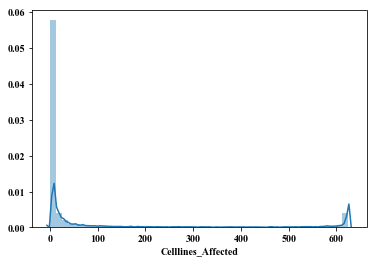

In [146]:
gene_effects = (essential_genes < -0.5).sum(axis=1)
gene_effects.name = 'Celllines_Affected'
pred_with_effects = predictions.join(gene_effects, on='Name')
sns.distplot(gene_effects)

Text(0, 0.5, '# Celllines Affected (Ranked)')

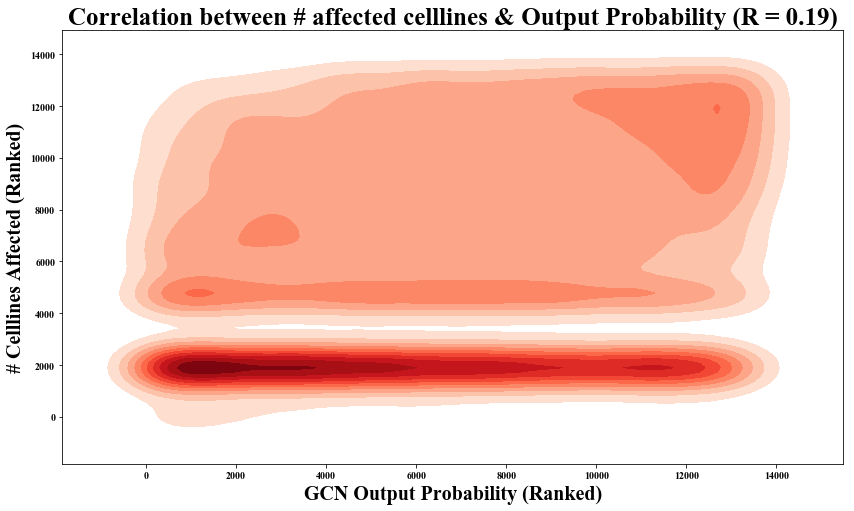

In [147]:
fig = plt.figure(figsize=(14, 8))
pred_with_effects['Effect_Rank'] = pred_with_effects.Celllines_Affected.rank()
pred_with_effects.Effect_Rank.fillna(0, inplace=True)
sns.kdeplot(pred_with_effects.Prob_pos.rank(), pred_with_effects.Effect_Rank, cmap='Reds',
            shade=True, shade_lowest=False)
plt.title('Correlation between # affected celllines & Output Probability (R = {0:.2f})'.format(pred_with_effects.Prob_pos.rank().corr(pred_with_effects.Effect_Rank)), fontsize=25)
plt.xlabel('GCN Output Probability (Ranked)', fontsize=20)
plt.ylabel('# Celllines Affected (Ranked)', fontsize=20)

In [187]:
consensus_cancergenes = pd.DataFrame(consensus_sorted, columns=['Name', 'Models_top100']).set_index('Name')

# add column for presence in NCG Candidate Cancer Genes
consensus_cancergenes['NCG_Candidates'] = consensus_cancergenes.index.isin(candidate_cancer_genes)

# add column for presence in OncoKB (anywhere there, not only high confidence)
oncokb_genes = pd.read_csv('/project/gcn/diseasegcn/data/pancancer/oncoKB/cancerGeneList.txt', sep='\t')
consensus_cancergenes['OncoKB'] = consensus_cancergenes.index.isin(oncokb_genes['Hugo Symbol'])

# add column for the number of cell lines in which the gene is essential (Achilles data)
consensus_effects = pd.DataFrame(target_scores, columns=['Name', 'Affected_Celllines']).set_index('Name')
consensus_cancergenes = consensus_cancergenes.join(consensus_effects)
consensus_cancergenes.to_csv(os.path.join(all_models_dir, 'consensus_candidates.tsv'), sep='\t')

In [205]:
high_conf_cancergenes = consensus_cancergenes[~consensus_cancergenes.NCG_Candidates & ~consensus_cancergenes.OncoKB & (consensus_cancergenes.Affected_Celllines < 30)]
high_conf_with_ens = high_conf_cancergenes.merge(predictions[['Name', 'label']], how='inner', left_index=True, right_on='Name')
high_conf_with_ens.columns = high_conf_with_ens.columns[:-1].tolist() + ['Training_Labels']
high_conf_with_ens = high_conf_with_ens[['Name', 'Models_top100', 'Affected_Celllines', 'Training_Labels', 'NCG_Candidates', 'OncoKB']]
high_conf_with_ens.to_csv(os.path.join(all_models_dir, 'consensus_nonaffected_notknown.tsv'), sep='\t')

In [62]:
pred_old = postprocessing.load_predictions('../data/GCN/training/final_TCGA_all_networks/CPDB/multiomics/')

In [66]:
pred_old.head(1000).Name.isin(predictions.head(1000).Name).sum()

723